In [9]:
# Standard imports
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import arviz
#import theano
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

import os, sys
sys.stderr = open(os.devnull, "w")

import pymc as pm
#import aesara.tensor as at 
#import aesara

In [10]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"] #.astype(theano.config.floatX)
county_idx, counties = pd.factorize(data.county)
coords = {"county": counties, "obs_id": np.arange(len(county_idx))}

<Axes: xlabel='y / y'>

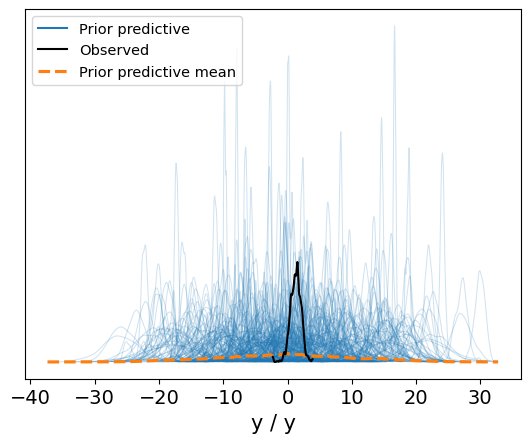

In [18]:
kwargs = {"emu_a": 0.0, "smu_a": 10., "ssigma_a": 1.0,
          "emu_b": 0.0, "smu_b": 2., "ssigma_b": 1.0, "eps": 1.5}

hierarchical_model = pm.Model(coords=coords)

with hierarchical_model:
    # Intercepts, non-centered
    mu_a = pm.Normal("mu_a", mu=kwargs["emu_a"], sigma=kwargs["smu_a"])
    sigma_a = pm.HalfNormal("sigma_a", kwargs["ssigma_a"])
    a = pm.Normal("a", dims="county") * sigma_a + mu_a
    
    # Slopes, non-centered parameterization
    mu_b = pm.Normal("mu_b", mu=kwargs["emu_b"], sigma=kwargs["smu_b"])
    sigma_b = pm.HalfNormal("sigma_b", kwargs["ssigma_b"])
    b = pm.Normal("b", dims="county") * sigma_b + mu_b
    
    eps = pm.HalfNormal("eps", kwargs["eps"])
    
    linear_predictor = a[county_idx] + b[county_idx] * data.floor.values
    
    y = pm.Normal(
        "y", mu=linear_predictor, sigma=eps, observed=data.log_radon, 
        dims="obs_id"
    )

    prior_predictive_data = pm.sample_prior_predictive()
    
arviz.plot_ppc(prior_predictive_data, group='prior')

In [12]:
with hierarchical_model:
    posterior_data = pm.sample(target_accept=0.9, draws=2000, tune=1000, chains=4, cores=4, progressbar=True)
    posterior_predictive_data = pm.sample_posterior_predictive(posterior_data)

<Axes: xlabel='y / y'>

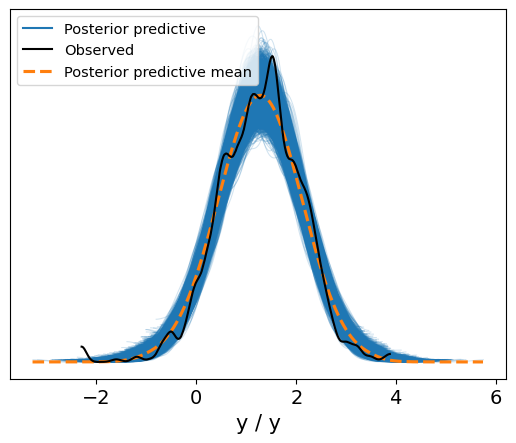

In [13]:
arviz.plot_ppc(posterior_predictive_data)

array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

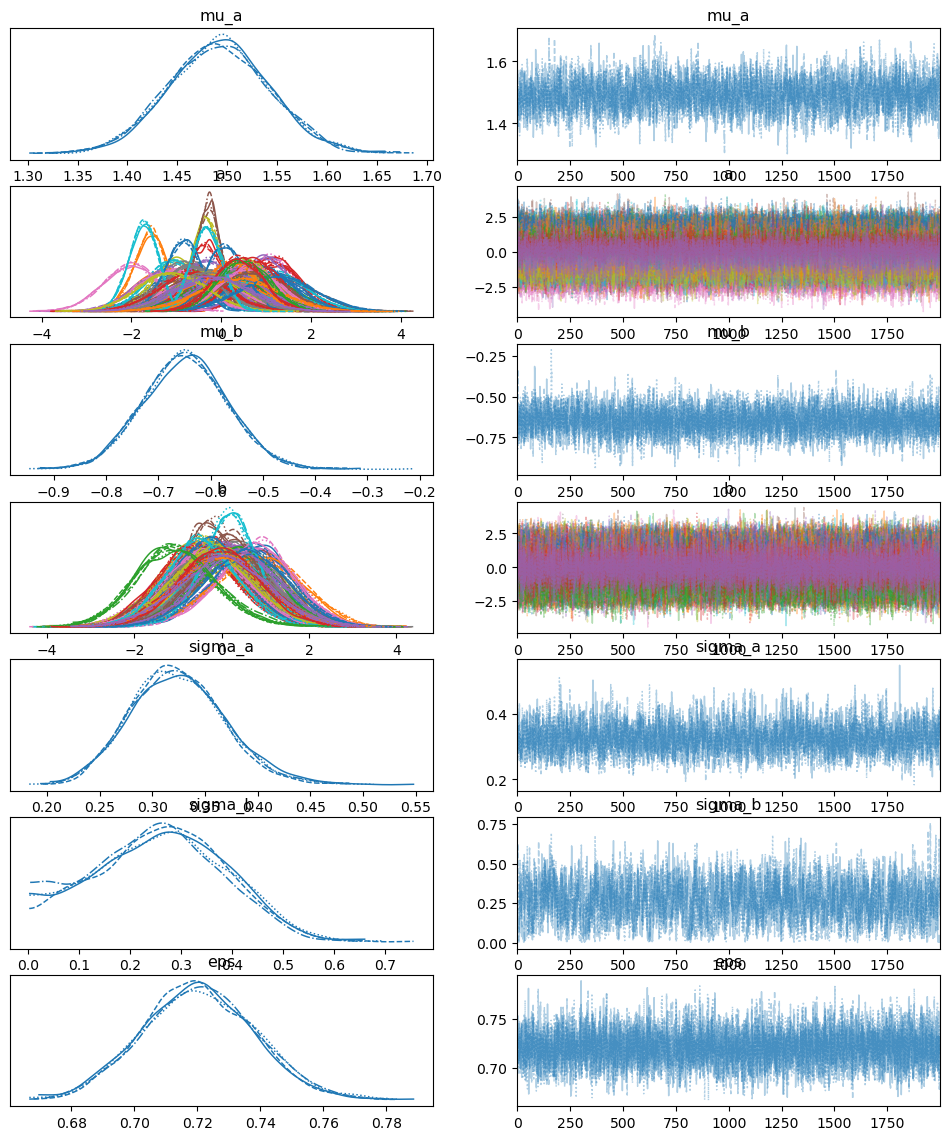

In [14]:
arviz.plot_trace(posterior_data)

array([[<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'b\nAITKIN'}>,
        <Axes: title={'center': 'b\nANOKA'}>],
       [<Axes: title={'center': 'b\nBECKER'}>,
        <Axes: title={'center': 'b\nBELTRAMI'}>,
        <Axes: title={'center': 'b\nBENTON'}>,
        <Axes: title={'center': 'b\nBIG STONE'}>],
       [<Axes: title={'center': 'b\nBLUE EARTH'}>,
        <Axes: title={'center': 'b\nBROWN'}>,
        <Axes: title={'center': 'b\nCARLTON'}>,
        <Axes: title={'center': 'b\nCARVER'}>],
       [<Axes: title={'center': 'b\nCASS'}>,
        <Axes: title={'center': 'b\nCHIPPEWA'}>,
        <Axes: title={'center': 'b\nCHISAGO'}>,
        <Axes: title={'center': 'b\nCLAY'}>],
       [<Axes: title={'center': 'b\nCLEARWATER'}>,
        <Axes: title={'center': 'b\nCOOK'}>,
        <Axes: title={'center': 'b\nCOTTONWOOD'}>,
        <Axes: title={'center': 'b\nCROW WING'}>],
       [<Axes: title={'center': 'b\nDAKOTA'}>,

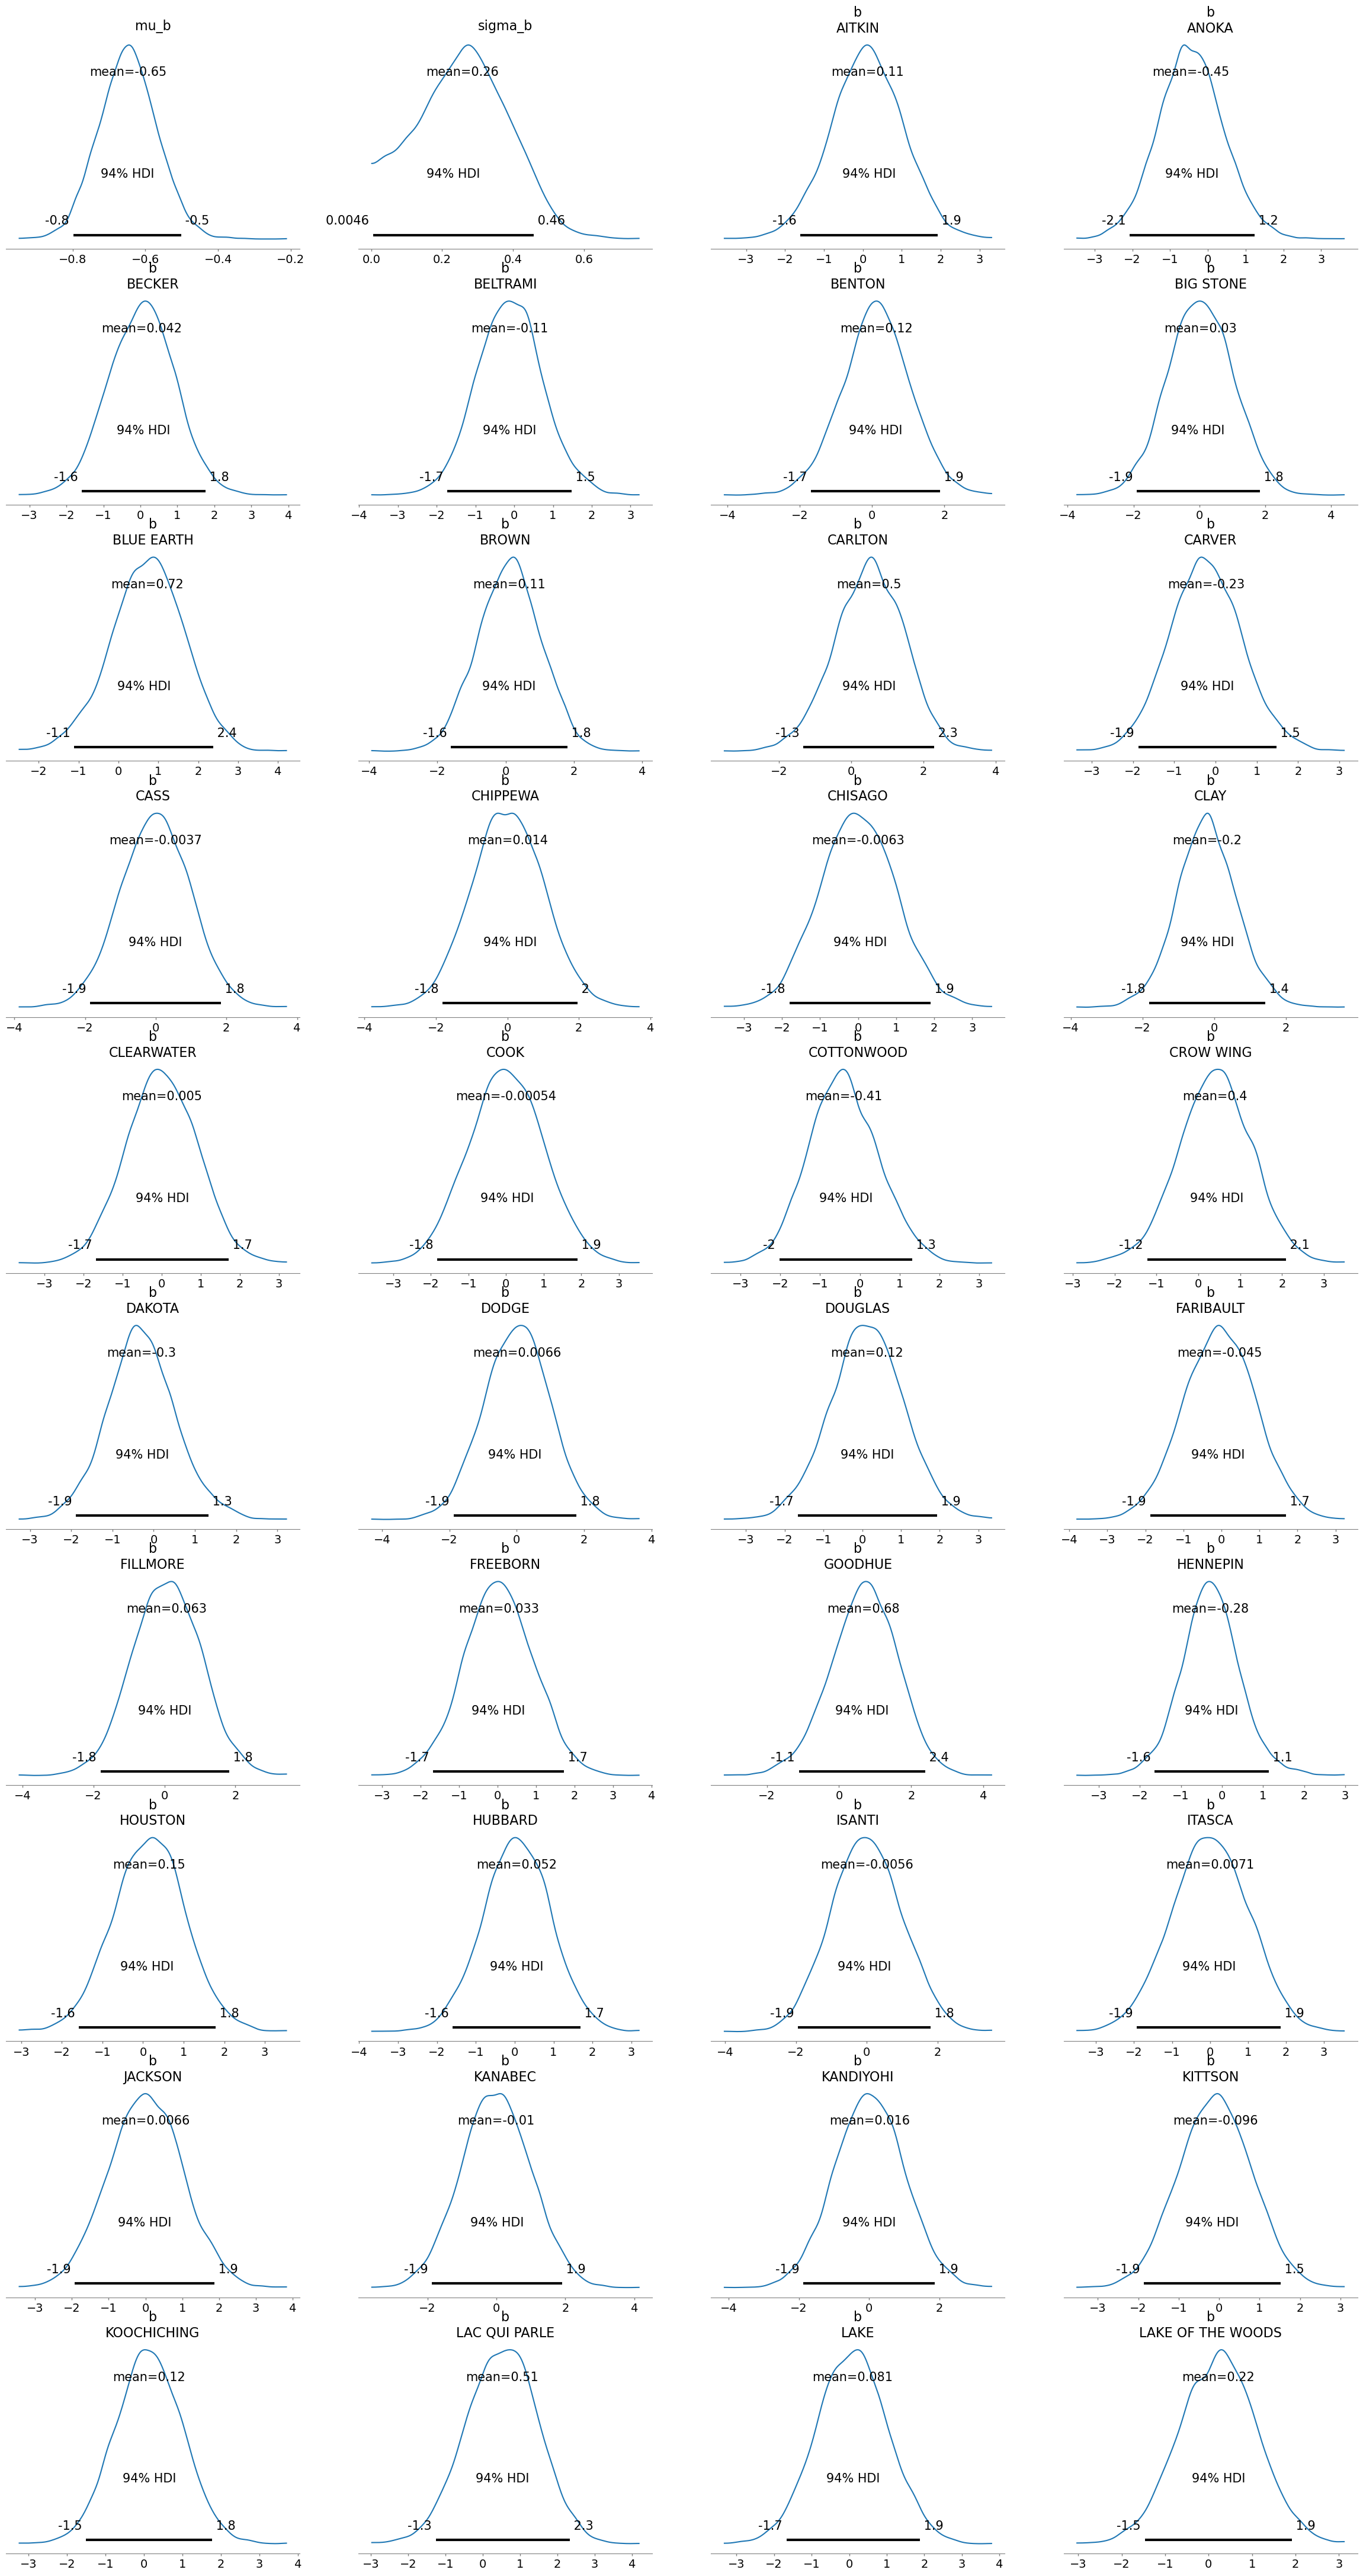

In [15]:
#posterior_data.to_dict()['posterior']['mu_b'].ravel()
arviz.plot_posterior(posterior_data, var_names=['mu_b', 'sigma_b', 'b'])